In [1]:
# library imports
import os
import glob

# plotting library
import matplotlib.pyplot as plt
import numpy as np

In [2]:
txt_files = glob.glob(os.path.join('C:\\Users\\Vinci\\Desktop\\Ice Crystal Program\\07142023\\', '*.txt'))
n_txt_files = len(txt_files)
batch_size = 4
file_batches = [txt_files[i:i + batch_size] for i in range(0, n_txt_files, batch_size)]

In [3]:
'''
Function to convert each element in a line to its correct corresponding data type.

Parameters:
line (str): A string representing a line from a file, containing elements of various data types.

Return:
converted_elements (list): A list containing elements converted to their appropriate data types: strings, integers, or floats.

Note:
The function assumes that the input line contains elements separated by delimiters (e.g., spaces or commas) 
and will attempt to convert each element to its respective data type. 
If a conversion is not possible, the element will remain as a string in the output list.

'''
def convert_line(line):
    elements = line.split(',')
    converted_elements  = []
    for element in elements:
        element = element.strip()
        try:
            element = int(element)
        except ValueError:
            try:
                element = float(element)
            except ValueError:
                pass
        converted_elements.append(element)
    return converted_elements 


'''
Function to read a txt file and create a 2D list containing each line as a list

Parameters:
filename(str): A string representing the name of the file

Return:
lines (2D list): list of all lines from file (lines converted to list)
'''
def parse_file_data(filename):
    lines = []
    quotes = str.maketrans('', '', '"')
    with open(filename, 'r') as file:
        for line in file:
            # remove any whitespace
            line = line.strip()
            if line:
                # creates a list for the line
                line = convert_line(line.translate(quotes))
                lines.append(line)
    return lines

In [4]:
def process_batch_ice_volume(batch):
    # files to read
    data_files = batch

    # 3D list ([[[]]]) that contains all lines from file as list
    file_data = []

    # list that contains lines as list composing only lines of ice volume data from each file. Length = # of files read
    ice_volume_total_image_area = []

    # read each file and get all lines as list, store them into file_data list. length = # of files
    for file in data_files:
        file_data.append(parse_file_data(file))

    # Get the total image area from ice volume data
    for data in file_data:
        ice_volume_total_image_area.append(data[4][1])
        
    return ice_volume_total_image_area

def process_batch_threshhold(batch):
    batch_data = {}

    # files to read
    data_files = batch

    # 3D list ([[[]]]) that contains all lines from file as list
    file_data = []

    # list that contains lines as list composing threshold data from each file. Length = # of files read
    threshold_file_data = []

    # read each file and get all lines as list, store them into file_data list. length = # of files
    for file in data_files:
        file_data.append(parse_file_data(file))

    # separate the ice_volume data from threshold data
    for data in file_data:
        threshold_file_data.append(data[11:])

    # column header/key defining threshold data values
    object_data_keys = file_data[0][10]

    # threshold data combining key and data values
    # threshold_data: list of dictionaries/hashmap of the threshold data from ALL files
    threshold_data = []

    # goes through each file
    for dataset in threshold_file_data:
        for data in dataset:
            # maps the key to its value for each object in a file
            threshold_data.append(dict(zip(object_data_keys, data)))

    # invert all roundness values r -> 1/r
    for file_object in threshold_data:
        file_object['Roundness'] = 1 / file_object['Roundness']

    # keep only objects with a roundness of 0.7 < (1/R) < 1.0
    filtered_threshold_data = []
    for object_data in threshold_data:
        object_roundness = object_data['Roundness']
        if 0.7 < object_roundness < 1.0:
            filtered_threshold_data.append(object_data)

    # Remove any duplicates based on the absolute difference of Centroid X,Y
    unique_objects = []

    filtered_threshold_data.sort(key=lambda x: x['Centroid X'])
    combined_n = len(filtered_threshold_data)
    for i in range(combined_n):
        uni_obj = True
        obj1 = filtered_threshold_data[i]
        for j in range(combined_n - 1, i, -1):
            obj2 = filtered_threshold_data[j]
            # Flags the object as a dup
            if abs(obj1['Centroid X'] - obj2['Centroid X']) < 0.2 and abs(obj1['Centroid Y'] - obj2['Centroid Y']) < 0.2:
                uni_obj = False
                break
        if uni_obj:
            unique_objects.append(obj1)

    # return the list of unique objects
    return unique_objects

In [5]:
def calculate_area(unique_objects):
    area = 0
    for uni_object in unique_objects:
        area += uni_object['Area']
    return area

def calculate_average_radii(unique_objects):
    average_radii = 0
    unique_len = len(unique_objects)
    for uni_object in unique_objects:
        average_radii += (uni_object['Equivalent Circle Diameter'] / 2)

    # calculate the average radii
    average_radii = (average_radii / unique_len) ** 3
    return average_radii

def calculate_ivf(ice_volume_data, area):
    total_image_area = 0
    for ice_volume in ice_volume_data:
        total_image_area += sum(ice_volume)
    ivf = area / total_image_area
    return ivf

In [6]:
batches_ice_volumes = [process_batch_ice_volume(batch) for batch in file_batches]
batch_files_data = [process_batch_threshhold(batch) for batch in file_batches]
batches_data = [
    {'Average Radii': calculate_average_radii(batch), 
     'IVF': calculate_ivf(batches_ice_volumes, calculate_area(batch))
    } 
    for batch in batch_files_data
]

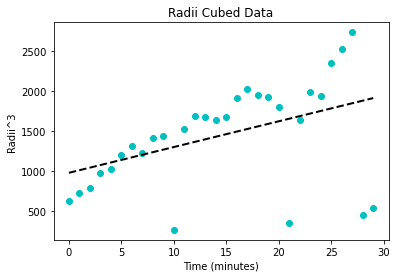

In [7]:
radii_cubed_data = np.array([b['Average Radii'] for b in batches_data])
ivf_data = np.array([b['IVF'] for b in batches_data])
x = range(len(batches_data))

# plot radii cubed data points
plt.figure()

# Add labels and title
plt.xlabel('Time (minutes)')
plt.ylabel('Radii^3')
plt.title('Radii Cubed Data')

# plot scatterplot and line of best fit 
a, b = np.polyfit(x, radii_cubed_data, 1)
plt.scatter(x, radii_cubed_data, color='c', marker='o', label='Radii^3 Data Points')
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2)

# Show the plot
plt.show()

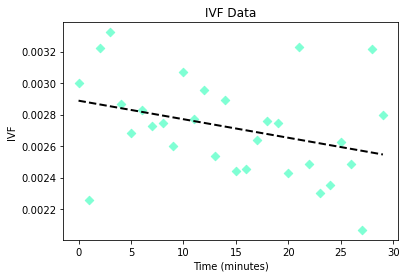

In [8]:
# plot IVF data
plt.figure()

# Add labels and title
plt.xlabel('Time (minutes)')
plt.ylabel('IVF')
plt.title('IVF Data')

# plot scatterplot and line of best fit 
a, b = np.polyfit(x, ivf_data, 1)
plt.scatter(x, ivf_data, color='aquamarine', marker='D', label='IVF Data Points')
plt.plot(x, a*x+b, color='black', linestyle='--', linewidth=2)

# Show plot
plt.show()